環境設定

In [ ]:
!pip install tf-nightly

In [ ]:
!pip install -q pyyaml h5py

import 函式庫

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
print(tf.__version__)

2.4.0-dev20200830


連接雲端帳號

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


參數設定

In [ ]:
batch_size = 32
img_height = 100
img_width = 100

training data 參數設定

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/My Drive/CNN/CNNData_zipped_2/CNNData/first',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9766 files belonging to 3 classes.
Using 7813 files for training.


validation data參數設定

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/drive/My Drive/CNN/CNNData_zipped_2/CNNData/first',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9766 files belonging to 3 classes.
Using 1953 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['ann', 'egg', 'iron']


下面是畫圖(看看data有沒有錯
training時不用做

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    print(labels)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

下面標準化的block先不用做

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

下面的block先不用做

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

vgg import 函式庫

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout2D, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop
from keras.callbacks import EarlyStopping
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.engine import training
from typing import Tuple
import time
#EStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
optimizer = RMSprop(lr=1e-4)

VGG model

In [ ]:
###
#vgg16
###
model_vgg = tf.keras.Sequential()
model_vgg.add(Conv2D(64,(3,3),strides=(1,1),input_shape=(100,100,3),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(Conv2D(64,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(MaxPooling2D(pool_size=(2,2)))
model_vgg.add(Conv2D(128,(3,2),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(Conv2D(128,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(MaxPooling2D(pool_size=(2,2)))
model_vgg.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(MaxPooling2D(pool_size=(2,2)))
model_vgg.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(MaxPooling2D(pool_size=(2,2)))
model_vgg.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(Conv2D(512,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
model_vgg.add(MaxPooling2D(pool_size=(2,2)))
model_vgg.add(Flatten())
model_vgg.add(Dense(4096,activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(4096,activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(3,activation='softmax'))
model_vgg.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 128)       49280     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 50, 50, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 25, 25, 256)      

下面是之前的model(非VGG

In [ ]:
num_classes = 3
model = tf.keras.Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

下面的block是之前配合上面非VGG model的block

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

training

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
History = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=60
)

Epoch 1/60


InvalidArgumentError: ignored

In [ ]:
History = model_vgg.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[cp_callback],
  epochs=3
)

Epoch 1/3
245/245 [==============================] - 8495s 34s/step - loss: 3.1943 - accuracy: 0.7196 - val_loss: 0.6842 - val_accuracy: 0.7793
Epoch 2/3
245/245 [==============================] - 3307s 13s/step - loss: 0.7624 - accuracy: 0.7648 - val_loss: 0.1717 - val_accuracy: 0.8966
Epoch 3/3
245/245 [==============================] - 3288s 13s/step - loss: 0.1664 - accuracy: 0.9405 - val_loss: 0.1052 - val_accuracy: 0.9575


save model

In [ ]:
#saving

import time
timestr = time.strftime("%Y%m%d_%H%M%S")
model_vgg.save('model_{}.h5'.format(timestr)) 

進入test data進入test data

In [ ]:
cd /content/drive/My Drive/CNN/CNNData_zipped_2/CNNData

/content/drive/My Drive/CNN/CNNData_zipped_2/CNNData


test

In [ ]:
#!ls
#!cat test2.py
!python3 test2.py iron_test

2020-08-30 09:55:41.318036: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-08-30 09:55:41.318083: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-08-30 09:55:43.263402: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-08-30 09:55:43.264498: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-08-30 09:55:43.270667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-30 09:55:43.271299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:

畫accuracy, loss的圖

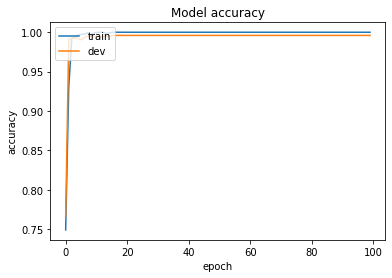

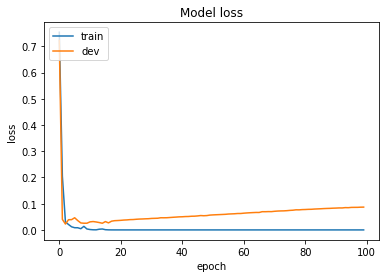

In [ ]:
# Training History
import collections
import pandas as pd
hist = History.history

for key, val in hist.items(): # Count the number of epoch
    numepo = len(np.asarray(val))
    break
hist = collections.OrderedDict(hist)
pd.DataFrame(hist).to_excel('model_{}_history.xlsx'.format(timestr), index=True)

import matplotlib.pyplot as plt

plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.savefig('Model_l accuracy_{}.png'.format(timestr))
plt.show()
plt.cla()

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.savefig('Model_l loss_{}.png'.format(timestr))
plt.show()
plt.close()

畫confuse matrics(未做)

Normalized confusion matrix
[[0.84 0.16 0.  ]
 [0.17 0.7  0.13]
 [0.02 0.12 0.86]]


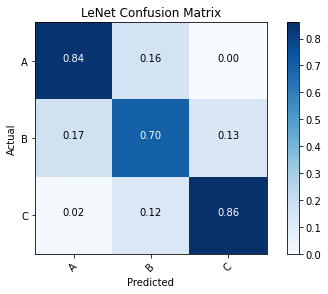

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model

def plot_confusion_matrix(cm, classes_x,classes_y,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.clf()
    plt.cla()
    plt.style.use('default')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid(False)
    plt.title(title)
    plt.colorbar()
    tick_marks_x = np.arange(len(classes_x))
    tick_marks_y = np.arange(len(classes_y))
    plt.xticks(tick_marks_x, classes_x, rotation=45)
    plt.yticks(tick_marks_y, classes_y)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(title+'.png',dpi=350 ,bbox_inches='tight')
    plt.show()
    plt.close()

test_pred  = model.predict(x_test)
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1).reshape(-1,1),
                              np.argmax(test_pred, axis=1).reshape(-1,1))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix,['A','B','C'],['A','B','C'],normalize=True,title='LeNet Confusion Matrix')

